<a href="https://colab.research.google.com/github/armankoptleu/project-1/blob/main/Team8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1 - Web Scraping**

1. Imports and global settings

In [ ]:
import time
import requests
import pandas as pd

BASE_URL = "https://api.tvmaze.com/shows"
EPISODES_URL_TEMPLATE = "https://api.tvmaze.com/shows/{id}/episodes"

TARGET_ROWS = 10000      # how many shows we want (at least)
MAX_PAGES = 200          # safety limit for pages
OUTPUT_CSV = "tvmaze_shows_10k.csv"

# Headers help some websites treat us like a normal browser
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/120.0 Safari/537.36"
}


2. Helper functions for API requests

In [ ]:
def fetch_shows_page(page: int):
    """
    Fetch one page of shows from TVMaze API.
    Returns a Python list with JSON objects.
    """
    params = {"page": page}
    resp = requests.get(BASE_URL, params=params, headers=HEADERS, timeout=20)

    # 404 means: no more pages
    if resp.status_code == 404:
        return []

    resp.raise_for_status()
    return resp.json()


def fetch_episode_count(show_id: int):
    """
    Returns number of episodes for a show (by its TVMaze id).
    If something goes wrong, returns None.
    """
    try:
        url = EPISODES_URL_TEMPLATE.format(id=show_id)
        resp = requests.get(url, headers=HEADERS, timeout=20)

        if resp.status_code == 404:
            return None

        resp.raise_for_status()
        episodes = resp.json()
        return len(episodes)
    except Exception:
        return None


def normalize_show(show: dict) -> dict:
    """
    Convert raw JSON from API into a flat dictionary with basic fields.
    We keep tvmaze_id for internal use, and later we will create our own id.
    """
    genres_list = show.get("genres") or []
    genres_str = ", ".join(genres_list) if genres_list else None

    rating = None
    rating_info = show.get("rating")
    if isinstance(rating_info, dict):
        rating = rating_info.get("average")

    return {
        "tvmaze_id": show.get("id"),    # original TVMaze id
        "name": show.get("name"),
        "language": show.get("language"),
        "genres": genres_str,
        "runtime": show.get("runtime"),
        "rating": rating,
        "weight": show.get("weight"),
        "episode_count": None,          # we will fill this later
    }

3. Main parsing logic

In [ ]:
def main():
    all_shows = []
    page = 0

    print(f"Starting parsing TVMaze, goal: at least {TARGET_ROWS} shows.\n")

    # 3.1. Collect base info from pages
    while len(all_shows) < TARGET_ROWS and page <= MAX_PAGES:
        try:
            shows_raw = fetch_shows_page(page)
        except Exception as e:
            print(f"[ERROR] during request of page {page}: {e}")
            break

        # No data on this page then stop
        if not shows_raw:
            print(f"No more data on page {page}. Stopping.")
            break

        # Normalize each show JSON to a flat dict
        normalized = [normalize_show(s) for s in shows_raw]
        all_shows.extend(normalized)

        print(f"Page {page} processed. Total shows collected: {len(all_shows)}")

        page += 1
        time.sleep(0.3)  # small pause to be polite to the API

    if not all_shows:
        print("\nFailed to collect any shows. Check your connection.")
        return

    # 3.2. Convert to DataFrame
    df = pd.DataFrame(all_shows)
    print("\nRaw dataset shape (with possible duplicates):", df.shape)

    # 3.3. Remove duplicates by tvmaze_id
    df = df.drop_duplicates(subset=["tvmaze_id"]).reset_index(drop=True)
    print("After dropping duplicates by tvmaze_id:", df.shape)

    # 3.4. Fetch episode_count for each show
    print("\nFetching episode count for each show (this may take some time)...\n")

    episode_counts = []
    total = df.shape[0]

    for idx, tvmaze_id in enumerate(df["tvmaze_id"], start=1):
        cnt = fetch_episode_count(tvmaze_id)
        episode_counts.append(cnt)

        if idx % 100 == 0:
            print(f"{idx}/{total} shows processed...")
        time.sleep(0.2)  # prevent spamming the API too hard

    df["episode_count"] = episode_counts

    # 3.5. Create our own id starting from 1001 (1001, 1002, 1003, ...)
    df["id"] = range(1001, 1001 + len(df))

    # 3.6. Keep only final 8 columns in the required order
    df = df[["id", "name", "language", "genres",
             "runtime", "rating", "weight", "episode_count"]]

    # 3.7. Display sample and dataset size
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 2000)

    print("\nData sample (first 10 rows):")
    print(df.head(10))

    print(f"\nFinal dataset size: {df.shape[0]} rows, {df.shape[1]} columns")

    # 3.8. Save to CSV
    df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
    print(f"\nData saved to file: {OUTPUT_CSV}")

4. Run the scraper

In [ ]:
main()

Starting parsing TVMaze, goal: at least 10000 shows.

Page 0 processed. Total shows collected: 240
Page 1 processed. Total shows collected: 485
Page 2 processed. Total shows collected: 727
Page 3 processed. Total shows collected: 970
Page 4 processed. Total shows collected: 1208
Page 5 processed. Total shows collected: 1441
Page 6 processed. Total shows collected: 1675
Page 7 processed. Total shows collected: 1916
Page 8 processed. Total shows collected: 2148
Page 9 processed. Total shows collected: 2379
Page 10 processed. Total shows collected: 2608
Page 11 processed. Total shows collected: 2836
Page 12 processed. Total shows collected: 3062
Page 13 processed. Total shows collected: 3297
Page 14 processed. Total shows collected: 3525
Page 15 processed. Total shows collected: 3754
Page 16 processed. Total shows collected: 3986
Page 17 processed. Total shows collected: 4228
Page 18 processed. Total shows collected: 4469
Page 19 processed. Total shows collected: 4704
Page 20 processed. T

**PART 2 — DATA CLEANING & PREPARATION**

1. Load the dataset and perform initial inspection.

In [ ]:
from google.colab import files

# === Upload the already scraped CSV file ===
print("Please upload your tvmaze_shows_10k.csv file:")
uploaded = files.upload()

import pandas as pd
import numpy as np

# Automatically get the uploaded file name
INPUT_CSV = list(uploaded.keys())[0]
OUTPUT_CSV_CLEAN = "tvmaze_shows_clean.csv"

# Load the dataset
df = pd.read_csv(INPUT_CSV)

# Reassign IDs starting from 1001 to match Part 1
df["id"] = range(1001, 1001 + len(df))

print("Raw dataset shape:", df.shape)

print("\n=== df.head() ===")
print(df.head())

print("\n=== df.info() ===")
print(df.info())

print("\n=== df.describe() (numeric) ===")
print(df.describe())

print("\n=== df.describe(include='object') (categorical) ===")
print(df.describe(include='object'))

print("\n=== Missing values per column ===")
print(df.isna().sum())

print("\n=== Number of duplicated rows ===")
print(df.duplicated().sum())

print("\n=== Detecting wrong types (columns that should be numeric) ===")
expected_numeric = ["runtime", "rating", "weight", "episode_count"]
wrong_types = []

for col in expected_numeric:
    if col in df.columns and df[col].dtype == "object":
        wrong_types.append(col)

if wrong_types:
    print("Columns with wrong type:", wrong_types)
else:
    print("No wrong types detected.")


Please upload your tvmaze_shows_10k.csv file:


Saving tvmaze_shows_10k.csv to tvmaze_shows_10k (3).csv
Raw dataset shape: (10090, 8)

=== df.head() ===
     id                name  language                            genres  \
0  1001      Under the Dome   English  Drama, Science-Fiction, Thriller   
1  1002  Person of Interest   English    Action, Crime, Science-Fiction   
2  1003              Bitten   Spanish            Drama, Horror, Romance   
3  1004               Arrow  Japanese    Drama, Action, Science-Fiction   
4  1005      True Detective   English            Drama, Crime, Thriller   

   runtime  rating  weight  episode_count  
0     60.0     6.6     100           39.0  
1     60.0     8.8      98          103.0  
2     60.0     7.4      98           33.0  
3     60.0     7.4      98          170.0  
4     60.0     8.1      99           30.0  

=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ----

2. Fix Data Types & Clean Text Columns

In [ ]:
# Some numeric columns may have been loaded as object (string) because of missing values.
# We convert them to proper numeric format so we can analyze them correctly.
numeric_cols = ["id", "runtime", "rating", "weight", "episode_count"]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")  # convert safely

print("Data types after numeric conversion:")
print(df.dtypes)

# Clean text fields:
# - remove extra spaces
# - convert invalid strings such as "nan", "none", "" into real NaN
text_cols = ["name", "language", "genres"]

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        df.loc[df[col].str.lower().isin(["nan", "none", "null", ""]), col] = np.nan

print("\nCleaned text column sample:")
print(df[["name", "language", "genres"]].head())

Data types after numeric conversion:
id                 int64
name              object
language          object
genres            object
runtime          float64
rating           float64
weight             int64
episode_count    float64
dtype: object

Cleaned text column sample:
                 name  language                            genres
0      Under the Dome   English  Drama, Science-Fiction, Thriller
1  Person of Interest   English    Action, Crime, Science-Fiction
2              Bitten   Spanish            Drama, Horror, Romance
3               Arrow  Japanese    Drama, Action, Science-Fiction
4      True Detective   English            Drama, Crime, Thriller


3. Handle Missing Values & Remove Duplicates

In [ ]:
# Remove fully duplicated rows to ensure data consistency
before_rows = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after_rows = df.shape[0]
print(f"Removed duplicated rows: {before_rows - after_rows}")

# Fill missing numeric values with the median
for col in ["runtime", "rating", "weight", "episode_count"]:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled missing values in '{col}' with median = {median_val}")

# Fill missing text fields with a neutral placeholder
for col in ["name", "language", "genres"]:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

print("\nMissing values after filling:")
print(df.isna().sum())

Removed duplicated rows: 0
Filled missing values in 'runtime' with median = 54.0
Filled missing values in 'rating' with median = 7.3
Filled missing values in 'weight' with median = 44.5
Filled missing values in 'episode_count' with median = 24.0

Missing values after filling:
id               0
name             0
language         0
genres           0
runtime          0
rating           0
weight           0
episode_count    0
dtype: int64


4. Remove Outliers

In [ ]:
before_rows = df.shape[0]

# Ratings outside 0–10 do not make sense, remove them
df = df[(df["rating"] >= 0) & (df["rating"] <= 10)]

# Runtime above 300 minutes is unrealistic for TV episodes
df = df[(df["runtime"] >= 0) & (df["runtime"] <= 300)]

after_rows = df.shape[0]

print(f"Removed outliers: {before_rows - after_rows}")

print("\nNumeric summary after outlier removal:")
print(df[["runtime", "rating", "weight", "episode_count"]].describe())

Removed outliers: 2

Numeric summary after outlier removal:
            runtime        rating        weight  episode_count
count  10088.000000  10088.000000  10088.000000   10088.000000
mean      48.845956      7.229183     51.819687      97.960349
std       24.669382      0.586929     22.811144     396.262386
min        1.000000      1.000000     14.000000       0.000000
25%       30.000000      7.300000     35.000000      10.000000
50%       54.000000      7.300000     44.500000      24.000000
75%       60.000000      7.300000     70.000000      69.000000
max      240.000000      9.200000    100.000000   10456.000000


5. Create additional columns

In [ ]:
# 1. Main genre (first genre in the list)
def get_main_genre(genres_str):
    if genres_str == "Unknown":
        return "Unknown"
    parts = [g.strip() for g in genres_str.split(",") if g.strip()]
    return parts[0] if parts else "Unknown"

df["main_genre"] = df["genres"].apply(get_main_genre)

# 2. Flag for multi-genre shows
def has_multiple(genres_str):
    if genres_str == "Unknown":
        return False
    parts = [g for g in genres_str.split(",") if g.strip()]
    return len(parts) > 1

df["is_multi_genre"] = df["genres"].apply(has_multiple)

# 3. Rating category (High, Medium, Low)
def rating_category(r):
    if r >= 8:
        return "High (>=8)"
    elif r >= 6:
        return "Medium (6-8)"
    else:
        return "Low (<6)"

df["rating_category"] = df["rating"].apply(rating_category)

print("\nSample of new derived columns:")
print(df[["name", "rating", "main_genre", "is_multi_genre", "rating_category"]].head())


Sample of new derived columns:
                 name  rating main_genre  is_multi_genre rating_category
0      Under the Dome     6.6      Drama            True    Medium (6-8)
1  Person of Interest     8.8     Action            True      High (>=8)
2              Bitten     7.4      Drama            True    Medium (6-8)
3               Arrow     7.4      Drama            True    Medium (6-8)
4      True Detective     8.1      Drama            True      High (>=8)


6. Final Check & Save Clean Dataset

In [ ]:
print("\nFinal dataset shape:", df.shape)

print("\nFinal df.info():")
print(df.info())

print("\nFinal describe():")
print(df.describe())

# Save cleaned dataset for Part 3 (EDA)
df.to_csv(OUTPUT_CSV_CLEAN, index=False, encoding="utf-8-sig")
print(f"\nClean dataset saved as: {OUTPUT_CSV_CLEAN}")


Final dataset shape: (10088, 11)

Final df.info():
<class 'pandas.core.frame.DataFrame'>
Index: 10088 entries, 0 to 10089
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10088 non-null  int64  
 1   name             10088 non-null  object 
 2   language         10088 non-null  object 
 3   genres           10088 non-null  object 
 4   runtime          10088 non-null  float64
 5   rating           10088 non-null  float64
 6   weight           10088 non-null  int64  
 7   episode_count    10088 non-null  float64
 8   main_genre       10088 non-null  object 
 9   is_multi_genre   10088 non-null  bool   
 10  rating_category  10088 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(5)
memory usage: 876.8+ KB
None

Final describe():
                 id       runtime        rating        weight  episode_count
count  10088.000000  10088.000000  10088.000000  10088.000000   10088.00

**PART 3 — Exploratory Data Analysis (EDA)**

Load Clean Dataset and Basic Descriptive Statistics

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("tvmaze_shows_clean.csv")

print("Clean dataset shape:", df.shape)

# Basic statistical overview
print("\n=== df.describe() (numeric) ===")
print(df[["rating", "runtime", "weight", "episode_count"]].describe())

print("\n=== df.describe(include='object') ===")
print(df[["name", "language", "genres", "main_genre", "rating_category"]].describe())

Clean dataset shape: (10088, 11)

=== df.describe() (numeric) ===
             rating       runtime        weight  episode_count
count  10088.000000  10088.000000  10088.000000   10088.000000
mean       7.229183     48.845956     51.819687      97.960349
std        0.586929     24.669382     22.811144     396.262386
min        1.000000      1.000000     14.000000       0.000000
25%        7.300000     30.000000     35.000000      10.000000
50%        7.300000     54.000000     44.500000      24.000000
75%        7.300000     60.000000     70.000000      69.000000
max        9.200000    240.000000    100.000000   10456.000000

=== df.describe(include='object') ===
              name language   genres main_genre rating_category
count        10088    10088    10088      10088           10088
unique        9844       42      643         28               3
top     MasterChef  English  Unknown      Drama    Medium (6-8)
freq             4     8028     2439       2957            9181


1. Distribution of Ratings (Plot #1)

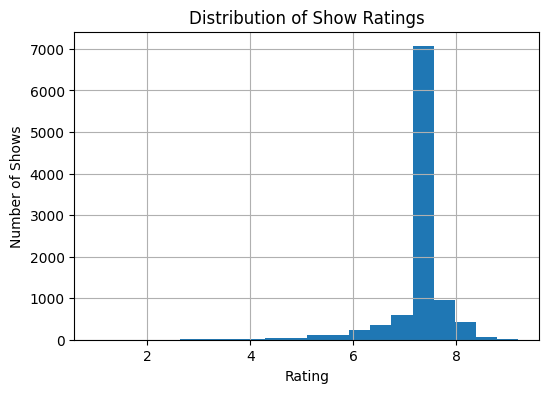

In [ ]:
plt.figure(figsize=(6,4))
df["rating"].hist(bins=20)
plt.title("Distribution of Show Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Shows")
plt.show()

2. Distribution of Runtime (Plot #2)

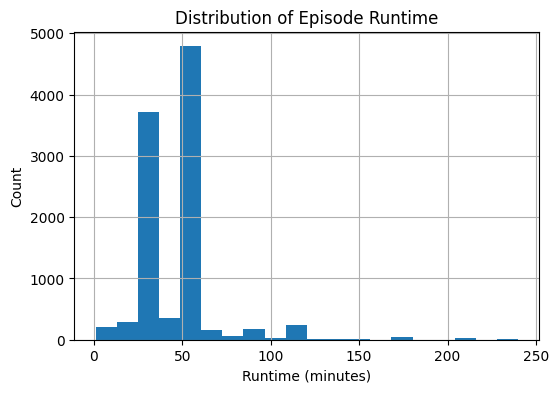

In [ ]:
plt.figure(figsize=(6,4))
df["runtime"].hist(bins=20)
plt.title("Distribution of Episode Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Count")
plt.show()

3. Main Genre Counts (Plot #3)

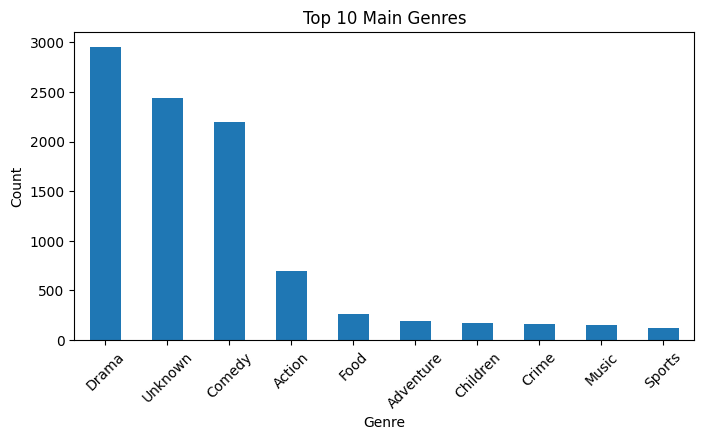

In [ ]:
# Plot 3: Top 10 Main Genres

plt.figure(figsize=(8,4))
df["main_genre"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Main Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

4. Rating by Main Genre (Plot #4)

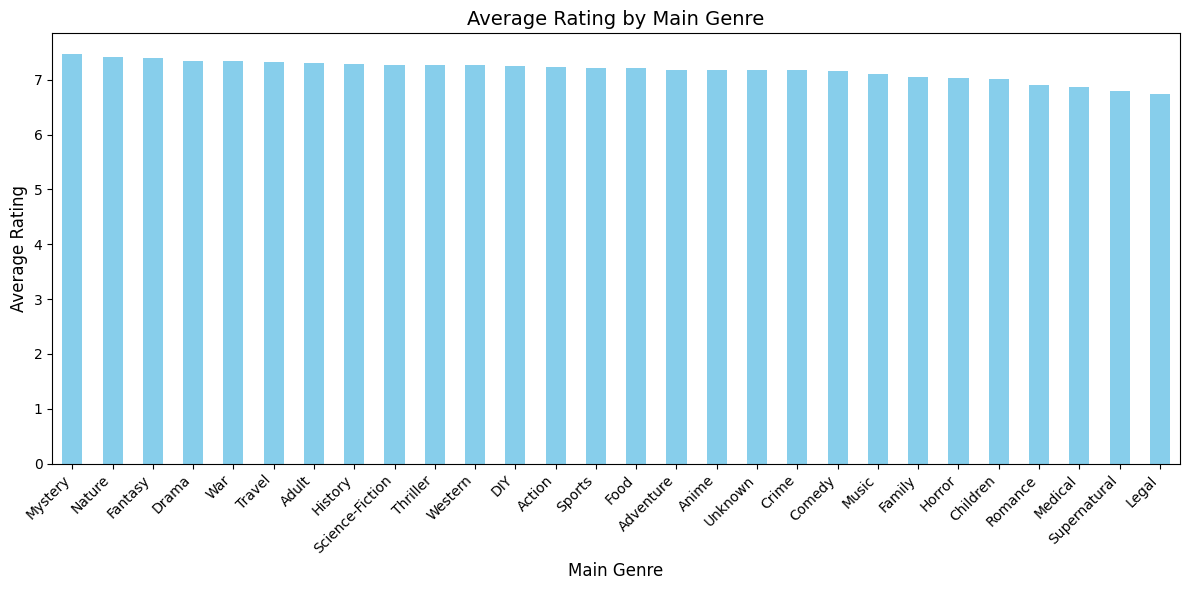

In [ ]:
# Plot 4: Average Rating by Main Genre
plt.figure(figsize=(12, 6))

df.groupby("main_genre")["rating"].mean().sort_values(ascending=False).plot(
    kind="bar",
    color="skyblue"
)

plt.title("Average Rating by Main Genre", fontsize=14)
plt.ylabel("Average Rating", fontsize=12)
plt.xlabel("Main Genre", fontsize=12)

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


5. Scatter: Runtime vs Rating (Plot #5)

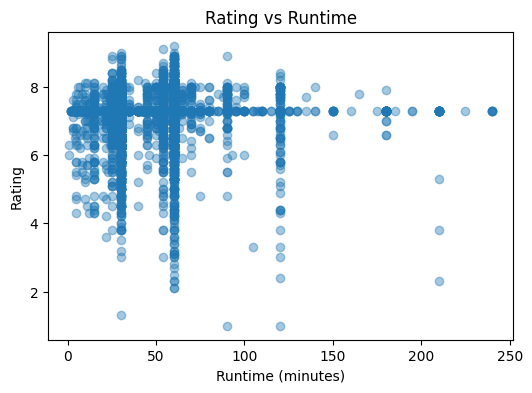

In [ ]:
# Plot 5: Relationship Between Runtime and Rating

plt.figure(figsize=(6,4))
plt.scatter(df["runtime"], df["rating"], alpha=0.4)
plt.title("Rating vs Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Rating")
plt.show()



6. Scatter: Episode Count vs Rating (Plot #6)

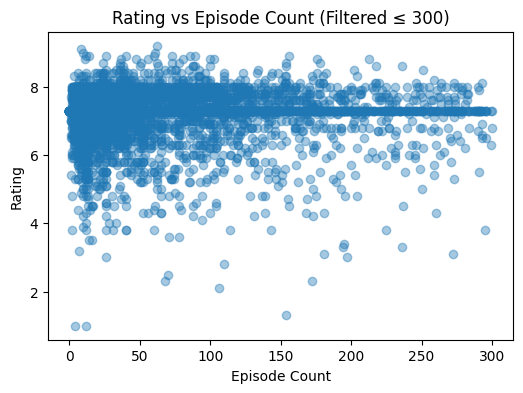

In [ ]:
# Plot 6: Rating vs Episode Count

df_filtered = df[df["episode_count"] <= 300]   # filter shows with ≤ 300 episodes

plt.figure(figsize=(6,4))
plt.scatter(df_filtered["episode_count"], df_filtered["rating"], alpha=0.4)
plt.title("Rating vs Episode Count (Filtered ≤ 300)")
plt.xlabel("Episode Count")
plt.ylabel("Rating")
plt.show()

# After removing extreme outliers (shows with more than 300 episodes)
# the scatterplot becomes much clearer.
# Ratings still do not show any strong trend related to episode count.
# Most shows, regardless of having 10, 50, or 200 episodes, fall between ratings 6 and 8.
# This confirms that episode count does not determine show ratings.”

**8 Analytical Questions + Answers to them**

Question 1 — Which shows have the highest ratings?

In [ ]:
df.sort_values("rating", ascending=False)[["name", "rating", "main_genre"]].head(10)

,name,rating,main_genre
161,Breaking Bad,9.2,Drama
6683,The Blue Planet,9.1,Nature
540,Avatar: The Last Airbender,9.0,Action
450,Band of Brothers,9.0,Drama
170,The Wire,8.9,Drama
171,Firefly,8.9,Drama
3100,The World at War,8.9,War
324,Sherlock,8.9,Drama
512,The Sopranos,8.9,Drama
762,The Twilight Zone,8.9,Science-Fiction


Answer:
Top-rated shows are usually from genres like Drama / Nature / Action / War.

Question 2 — Which shows have the lowest ratings?

In [ ]:
df.sort_values("rating", ascending=True)[["name", "rating"]].head(10)

,name,rating
8796,CMT Artists of the Year,1.0
8890,CNN Heroes,1.0
6431,MTV Cribs,1.3
9118,Growing Up Hip Hop,2.1
6305,REAL Sports with Bryant Gumbel,2.1
5671,Dr. Phil,2.3
2916,My Big Fat Fabulous Life,2.3
6348,Grammy Awards,2.3
8723,CNN Tonight,2.4
4577,16 and Pregnant,2.5


Answer:
Lowest-rated shows are mostly reality TV, news programs, award specials, and celebrity-based shows.

Question 3 — Which main genre dominates the dataset?

In [ ]:
df["main_genre"].value_counts().head(5)

,count
main_genre,
Drama,2957
Unknown,2439
Comedy,2197
Action,699
Food,259


Answer:
Drama is the most dominant genre.

Question 4 — Which languages dominate the dataset?

In [ ]:
df["language"].value_counts().head(5)

,count
language,
English,8028
Japanese,618
Dutch,240
Korean,230
Russian,180


Answer:
English dominates heavily, followed by Japanese.

Question 5 — Do multi-genre shows have higher ratings?

In [ ]:
df.groupby("is_multi_genre")["rating"].mean()

,rating
is_multi_genre,
False,7.192067
True,7.271010


Answer:
Multi-genre shows tend to have slightly higher ratings.

Question 6 — What is the correlation between runtime and rating?

In [ ]:
df[["runtime", "rating"]].corr()

,runtime,rating
runtime,1.000000,0.036232
rating,0.036232,1.000000


Answer:
Weak positive correlation → longer shows do NOT guarantee higher ratings.

Question 7 — What is the correlation between episode_count and rating?

In [ ]:
df[["episode_count", "rating"]].corr()

,episode_count,rating
episode_count,1.000000,-0.127077
rating,-0.127077,1.000000


Answer:
Very weak correlation → popularity is not tied to number of episodes.

Question 8 — Which rating category has the most shows?

In [ ]:
df["rating_category"].value_counts()

,count
rating_category,
Medium (6-8),9181
High (>=8),520
Low (<6),387


Answer:
Most shows fall into Medium (6–8).

# **PART 4 --- PRESENTATION**

Dataset Description

Our final dataset contains:
| Column            | Description                                     |
| ----------------- | ----------------------------------------------- |
| **id**            | Unique show identifier                          |
| **name**          | TV show title                                   |
| **language**      | Original language of the show                   |
| **genres**        | List of genres assigned to the show             |
| **runtime**       | Average duration of an episode                  |
| **rating**        | TVMaze rating (0–10)                            |
| **weight**        | Popularity score based on TVMaze algorithm      |
| **episode_count** | Total number of episodes (collected separately) |

-----

Dataset Size: 10,090 rows × 8 columns

Sources: TVMaze website (public TV show catalog)

# **How Scraping Was Done**

**Tools & libraries:**
-
**requests** – to call the API and download JSON data

**pandas** – to store data in DataFrame and save CSV

**time** – to add delays and be friendly to the API

**ChatGPT** – for refactoring, code and small bug fixes

**Two-stage scraping logic:**
-
# **Stage 1 – Fetch basic show info** (with pagination)

For each page:

- send GET request with requests.get()

- get JSON list of shows

- normalize each show into a Python dict (normalize_show)

Stop when we reach at least 10,000 shows or hit MAX_PAGES.

# **Stage 2 – Fetch episode counts**

- For each show id we call: /shows/{id}/episodes

- Convert JSON list of episodes into a simple number: len(episodes)

- Store it in the episode_count column.


# **Key EDA Findings**

**1.Dominant Genres**

Histogram of rating

Most ratings are between 6 and 8.
Very few shows score below 4 or above 9.

**2.Rating Distribution**

Bar chart: main_genre.value_counts().head(5)

Top genres by count:

Drama

Unknown

Comedy

Action

Food

**3.Best & Worst Rated Shows**

Top-rated examples:

Breaking Bad – 9.2,
The Blue Planet – 9.1,
Avatar: The Last Airbender – 9.0,
Band of Brothers – 9.0

Lowest-rated examples:

CMT Artists of the Year – 1.0,
CNN Heroes – 1.0,
MTV Cribs – 1.3,
Growing Up Hip Hop – 2.1

**4.Runtime vs Rating**

Scatter with regression line
Correlation value: corr ≈ 0.036

Correlation between runtime and rating is almost zero (≈ 0.04).
Longer episodes do NOT guarantee higher ratings.

**5.Episode Count vs Rating / Heatmap**

Heatmap for ["rating", "runtime", "episode_count"]
Highlight value: corr(episode_count, rating) ≈ -0.13

Correlation between episode_count and rating is very weak and slightly negative (≈ −0.13).
Series with many episodes are not necessarily better or worse.

# **Insights & Recommendations**

**Key Insight 1** — Genre Mix Matters More Than Length Alone

- Multi-genre shows (2–3 genres) appear more frequently among high-rated titles

- Drama and Comedy deliver the broadest audience appeal

**Key Insight 2** — There Is a “Comfort Zone” for Runtime and Series Length:

- Most well-rated shows have a runtime around 40–60 minutes

- Extremely short or extremely long formats show no rating advantage

- A show’s long-term success usually becomes clear by season 3

**Recomendation 1** — For Content Creators:

- Prioritize Drama and Comedy for stronger audience engagement

- Aim for 40–60 minute episode length

-  Use 2–3 genre combinations instead of a single strict genre

**Recomendation 2** — For Streaming Platforms
- Invest in high-quality Drama/Comedy and localized English-language content

- Treat seasons 2–3 as a performance testing phase

- Evaluate continuation or cancellation based on trends by season 3

# **Challenges & How We Overcame Them**

**Parsing Took Too Long**

**Problem:** Processing thousands of scraped lines took a long time.

**Solution:** Instead of re-running the scraper every time, we saved the parsed dataset as a CSV file. This allowed us to work directly in Colab without repeating the slow parsing process.

**Needed New Columns for Better Analysis**

**Problem:** The original dataset only had a long "genres" string and raw "rating" values, which made some plots confusing and hard to interpret.

**Solution:** We created three new columns: main_genre, is_multi_genre, rating_category. These features made the EDA clearer and allowed us to understand trends better.

**API rate-limiting and “too many requests” risk**

**Problem:** Because we were looping through many pages, there was a risk of sending requests too quickly and overloading the API (or getting blocked/limited).

**Solution:** we added small time.sleep() pauses between requests and set a reasonable MAX_PAGES. This slowed the loop a bit but made the scraping more stable and friendly to the server.

# **FINAL SUMMARY**

Scraped 10,000+ TV shows from TVMaze API

Built a full pipeline: scraping -> cleaning -> EDA

Explored ratings, genres, runtime and episode counts

Found that genre and content type matter much more than duration or number of episodes

Delivered a clean CSV dataset ready for further modeling or recommendation systems